In [388]:
import tabulator
from urllib.request import urlretrieve
import csv
import json
from math import exp
from statistics import mean, stdev, median

In [389]:
def stripstr(s):
    if s is not None: return ' '.join(s.split()).strip() 

def process_gsheet():
    urlretrieve('https://docs.google.com/spreadsheets/d/e/2PACX-1vQ9VOjw8JrOa-8fzcnlRuooY6e8I1Bm6f-IZOzhrOYXf8RY0cfqfT-5aL11WTA3MqLG3GEaDlW0iNB-/pub?output=xlsx', 'data.xlsx')
    for sheet in range(1, 4):
        print('SHEET', sheet)
        s=tabulator.Stream('data.xlsx', sheet=sheet, headers=1)
        try:
            s.open()
            prevkey = None
            prevret = {}
            for r in s.iter(keyed=True):
                # is valid row?
                if r['value'] is None or len(str(r['value']).strip()) == 0:
                    continue
                # copy values from the previous row
                ret = dict(
                    (k, prevret.get(k))
                    for k in ('category', 'series', 'subseries', 'calc', 'year', 'value_docuemtation')
                )
                # update with values from the current row
                for k, v in r.items():
                    if not k:
                        continue
                    if v:
                        ret[k] = v
                    else:
                        if k not in ret:
                            ret[k] = None
                # if series changed - reset value documentation
                key = '{category}/{series}/{subseries}'.format(**r)
                if key != prevkey:
                    ret['value_docuemtation'] = None
                # process datatypes a tad
                for k, f in (
                    ('year', int), 
                    ('extrapulation', bool), 
                    ('category', stripstr), 
                    ('series', stripstr), 
                    ('subseries', stripstr)
                ):
                    ret[k] = f(ret.get(k))
                    
                yield ret
                prevkey, prevret = key, ret
                    
        except tabulator.exceptions.SourceError:
            break

In [390]:
def collate_series(rows):
    series = {}
    for r in rows:
        key = '{category}/{series}/{subseries}'.format(**r)
        values = series.setdefault(key, {
            'kind': 'series',
            'category': r['category'],
            'series': r['series'],
            'subseries': r['subseries'],
            'title': r['subseries'],
            'calc': r['calc'],
            'values': []
        })['values']
        values.append({
            'year': r['year'],
            'value': r['value'],
            'value_cmp': r['value_cmp'],
            # TODO: copy src_url, src_title, value_docuemtation, extrapulation
        })
    return series
    


In [391]:
def two_parts(v1, v2):
    ratio = v1/(v1+v2)
    assert 0 <= ratio <= 1
    score = 100*(exp(    
        -((ratio-0.5)**2) / (2*(0.16**2))
    ))
    return score

In [392]:
def two_parts_percent(v1, v2):
    assert 0 <= v1 <= 1
    if v2 is None:
        v2 = 1 - v1
    return two_parts(v1, v2)

In [393]:
def two_values(v1, v2):
    return two_parts(v1, v2)

In [394]:
def calc_scores(series):
    for k, s in series.items():
        calc = globals()[s['calc']]
        for v in s['values']:
            v['score'] = calc(v['value'], v['value_cmp'])
    return series


In [403]:
def calc_averages(series, kf='{category}', title=None):
    avgs = {}
    for s in series.values():
        k = kf.format(**s)
        a = avgs.setdefault(k, {
            'kind': 'avg' if kf != 'total' else 'total',
            'category': k,
            'title': title if title is not None else k,
#             'series': set(),
            'values': {}
        })
#         a['series'].add(s['title'])
        for v in s['values']:
            a['values'].setdefault(v['year'], []).append(v['score'])
    for a in avgs.values():
        values = []
        for year, scores in a['values'].items():
            values.append({
                'year': year,
                'score': mean(scores),
                'error': stdev(scores) if len(scores)>1 else 0,
                'count': len(scores)
            })
        median_count = median(map(lambda x:x['count'], values))
        a['values'] = sorted(filter(lambda x:x['count']>=median_count, values), key=lambda v:v['year'])
#         a['series'] = list(a['series'])
    series.update(avgs)
    if len(avgs) > 1:
        series.update(calc_averages(avgs, kf='total', title='מדד המגדר'))
    return series
            

In [412]:
series = collate_series(process_gsheet())
series = calc_scores(series)
series = calc_averages(series)


SHEET 1
SHEET 2
SHEET 3


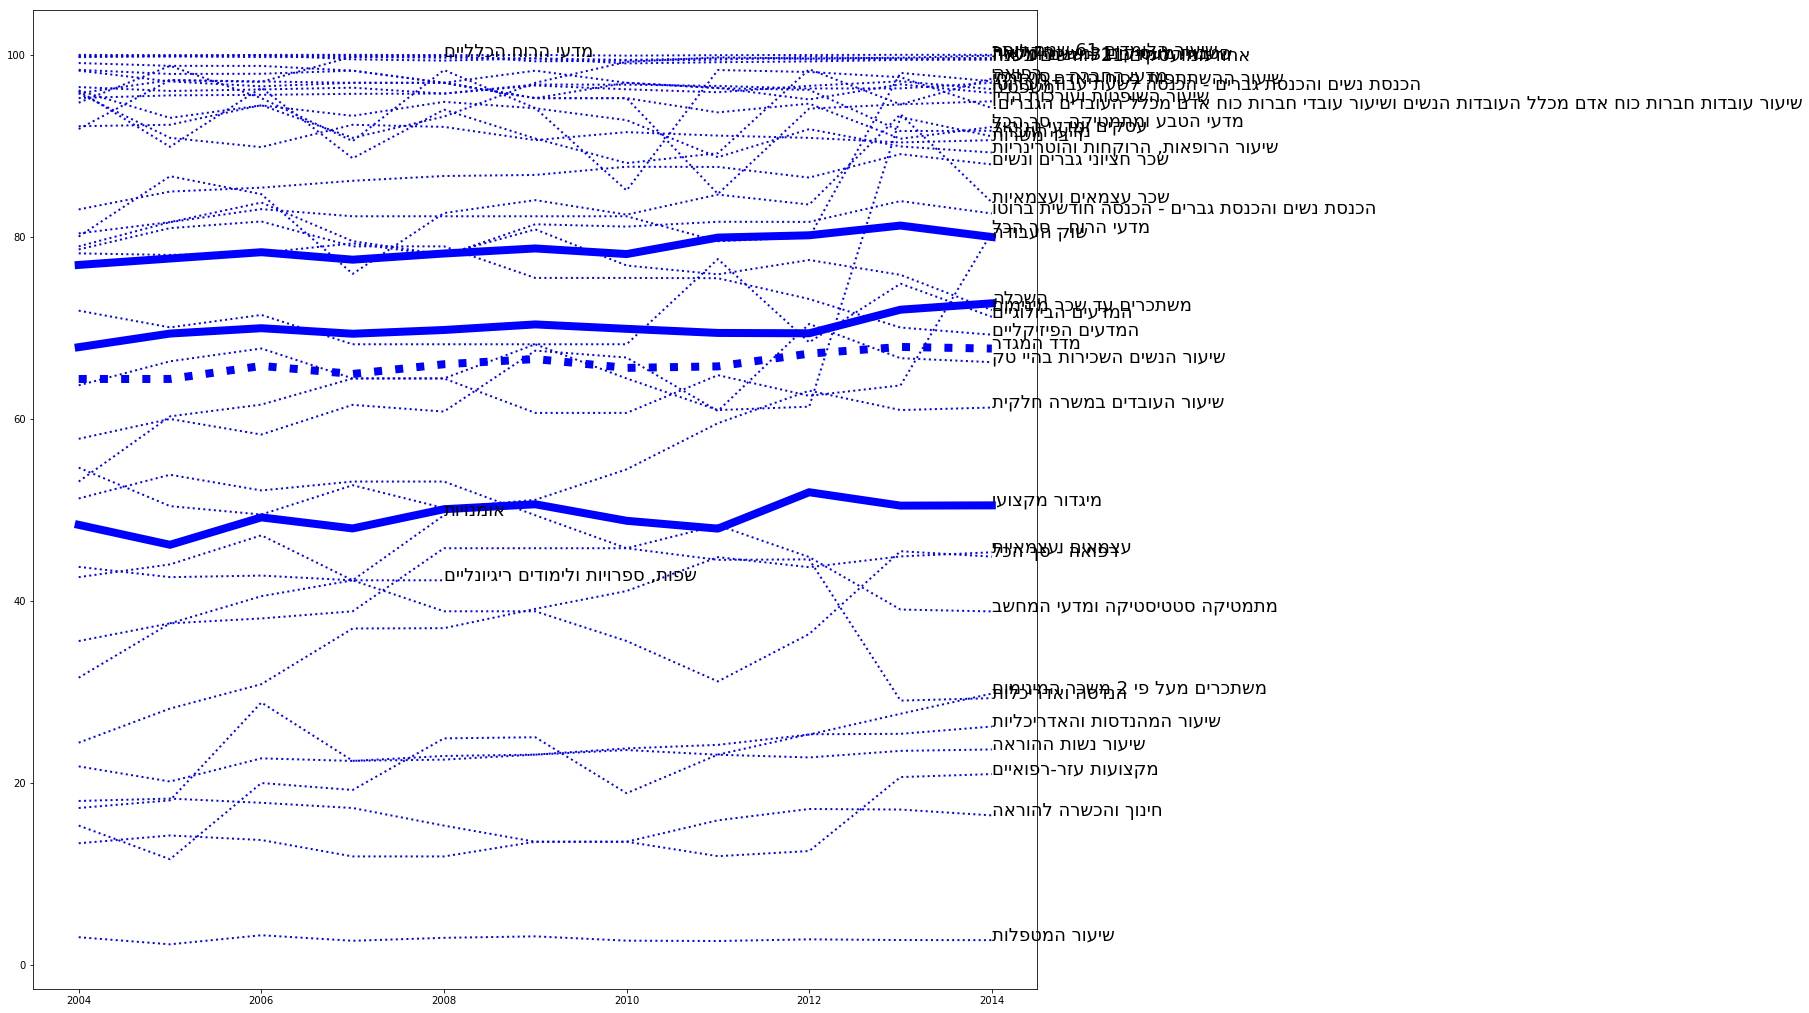

In [413]:
from pprint import pprint
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (18, 18)

def reverse(s): return ''.join(reversed(s))
filtered = [(k, s) for k, s in series.items()]# if k.startswith('מיגדור מקצועי/')]

minyear = max(min(x['year'] for x in s['values']) for _, s in filtered)
maxyear = 2014 # min(max(x['year'] for x in s['values']) for _, s in filtered)
for k, s in filtered:
    s['values'] = list(filter(lambda v: maxyear >= v['year'] >= minyear, s['values']))
    s['key'] = k
filtered = [s for k, s in filtered] 

json.dump(filtered, open('filtered.json', 'w'))

for s in filtered:
    width = 2**(4-len(s['key'].split('/')))
    style = 'b-' if s['kind'] == 'avg' else 'b:'
    y = [v['score'] for v in s['values']]
    x = [v['year'] for v in s['values']]
    plt.plot(x, y, style, linewidth=width)
    plt.text(x[-1], y[-1], reverse(s['title']), fontsize=18)
plt.show()

w = csv.DictWriter(open('data.csv', 'w'), [
    'category', 'series', 'subseries', 
    'calc', 'year', 
    'value', 'value_cmp', 
    'src_url', 'src_title', 
    'value_docuemtation', 'extrapulation'
])
w.writeheader()
w.writerows(it)